In [1]:
#import libraries
import pandas as pd
import numpy as np
import os

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn related libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras NN related libraries
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from collections import OrderedDict

In [51]:
#load data(
file_path = 'creditcard.csv'
df = pd.read_csv(file_path)

Data preparation

In [52]:
#Data Cleaning
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [53]:
# Counting NaN or missing values in each column (Checks for missing values in the dataset.)
nan_values = df.isna().sum()
print("Number of NaN values in each column:\n", nan_values)

Number of NaN values in each column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [54]:
# Print the data types of each column
print(df.dtypes)

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


In [55]:
print(df['Class'].value_counts())

0    284315
1       492
Name: Class, dtype: int64


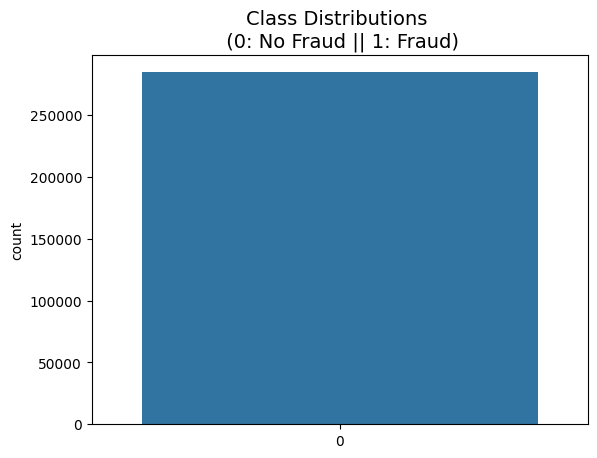

In [56]:
#data Visualization
#class distribution
sns.countplot(df['Class'])
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

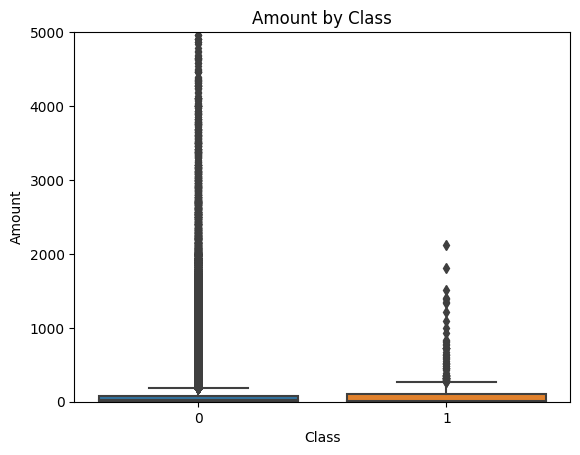

In [57]:
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Amount by Class")
plt.ylim(0, 5000)  # Limiting display range for better visibility
plt.show()

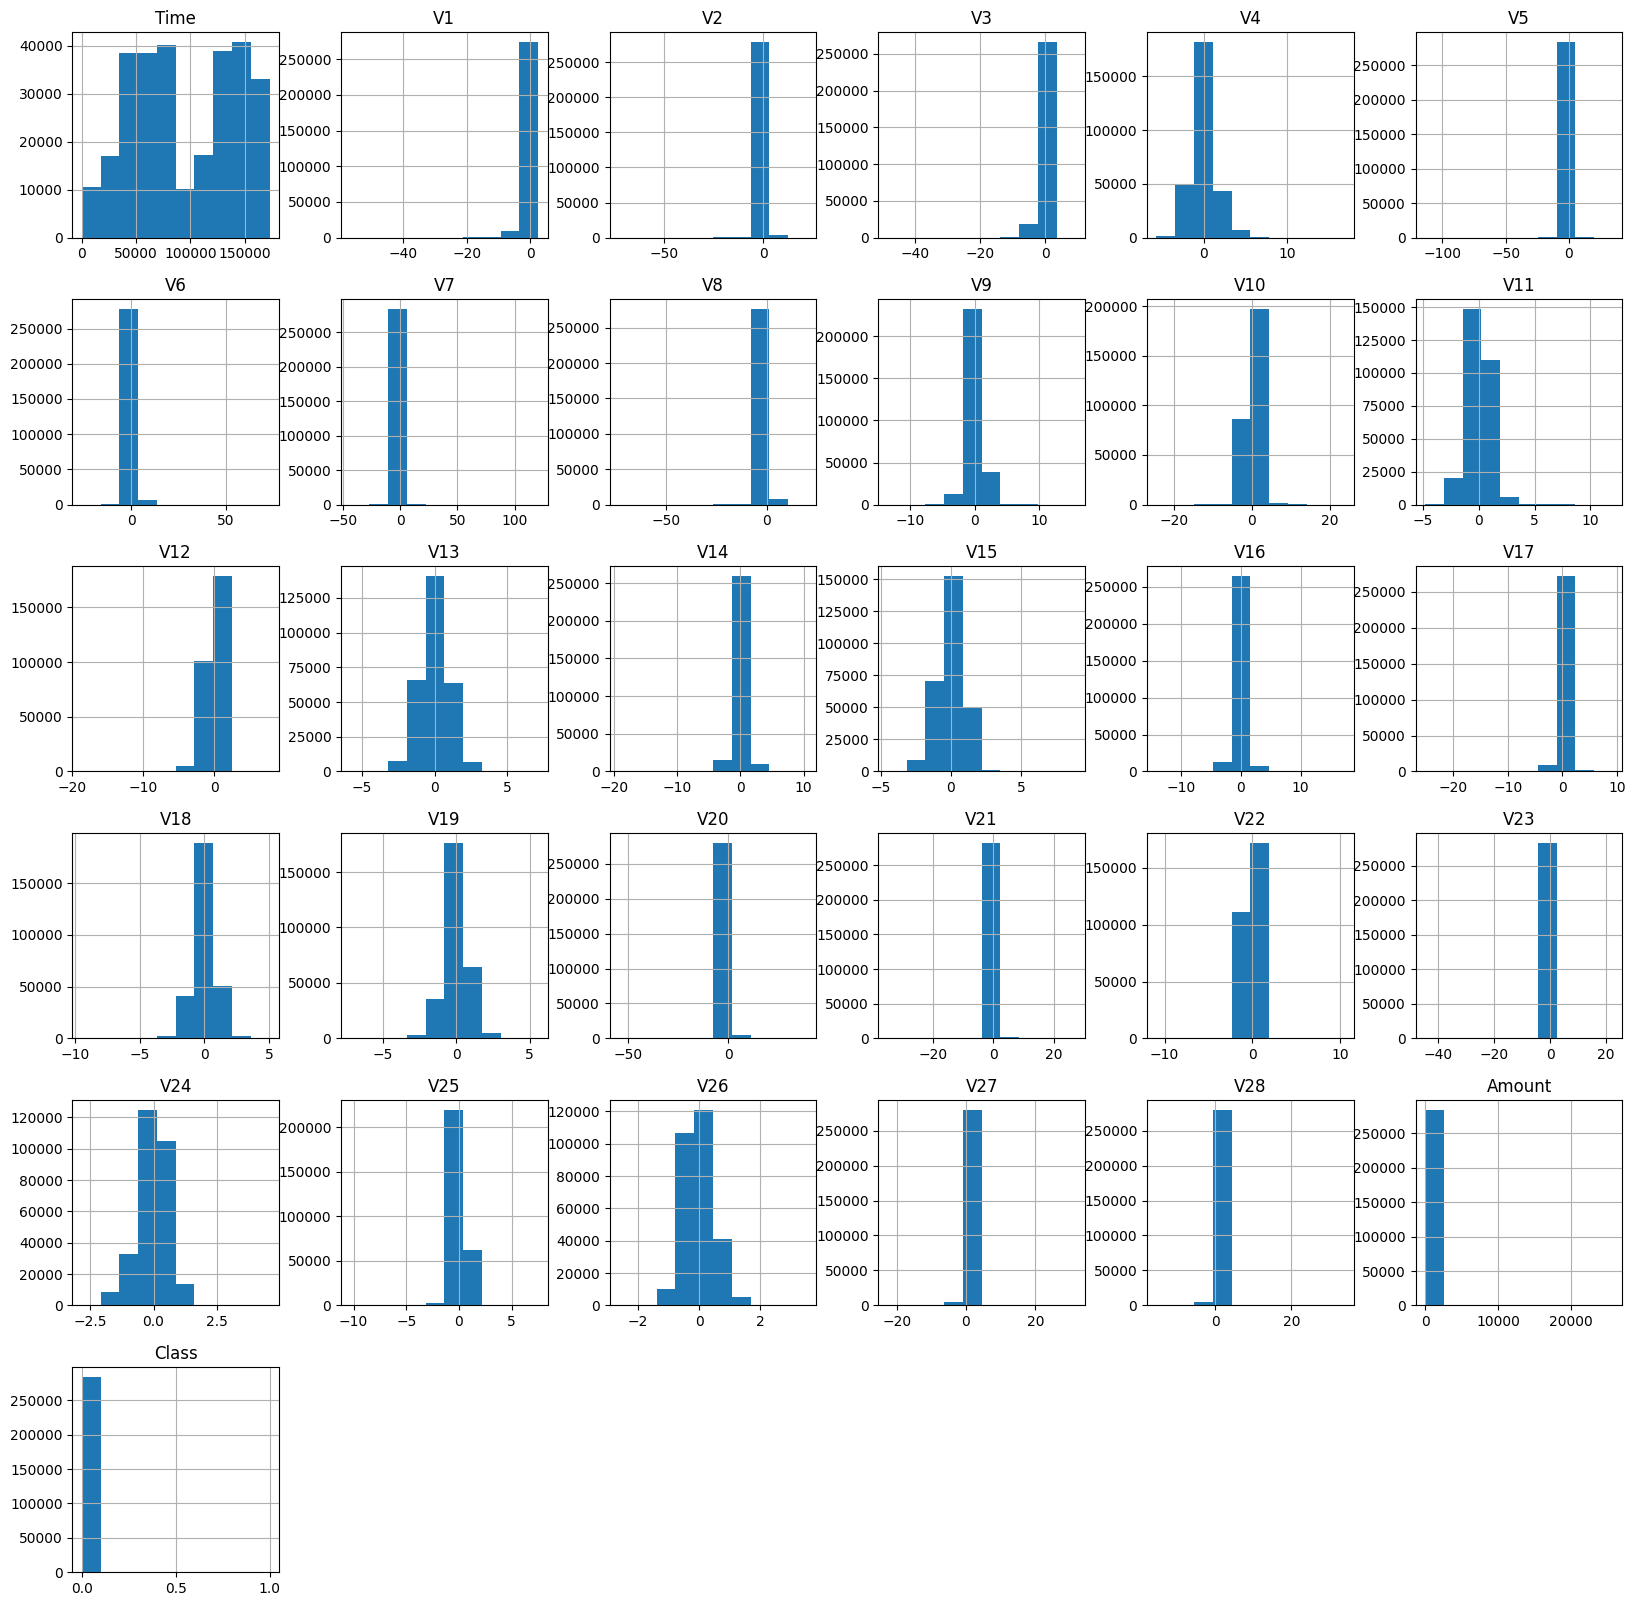

In [58]:
# Visualize histograms of numerical features
df.hist(figsize=(20,20))
plt.show()

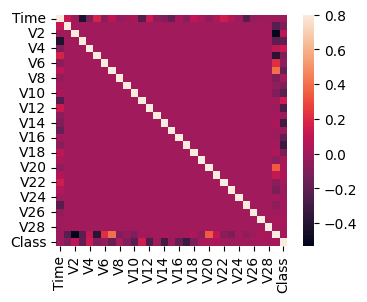

In [59]:
# Visualize correlation matrix as a heatmap
corr_matrix = df.corr()
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, vmax=0.8, square=True)
plt.show()

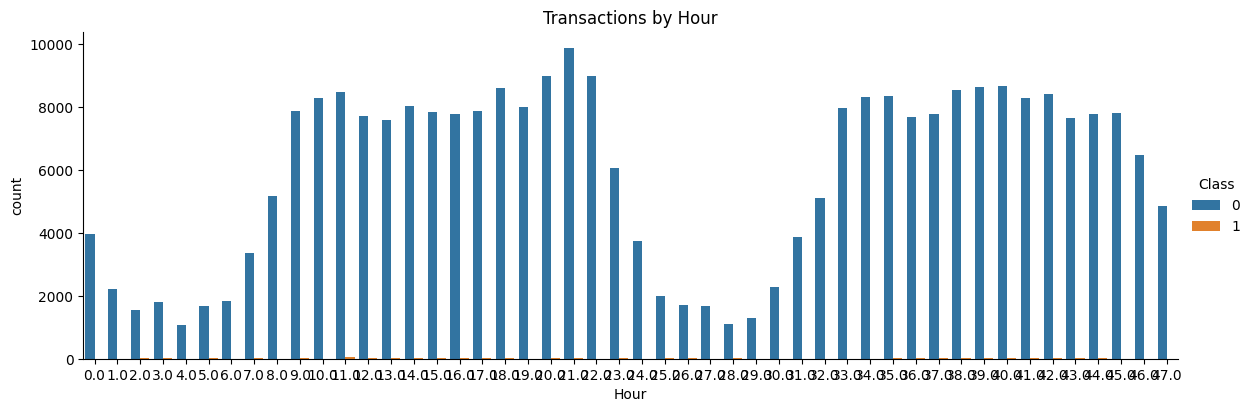

In [60]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))
sns.catplot(x='Hour', data=df, kind='count', hue='Class', height=4, aspect=3)
plt.title('Transactions by Hour')
plt.show()

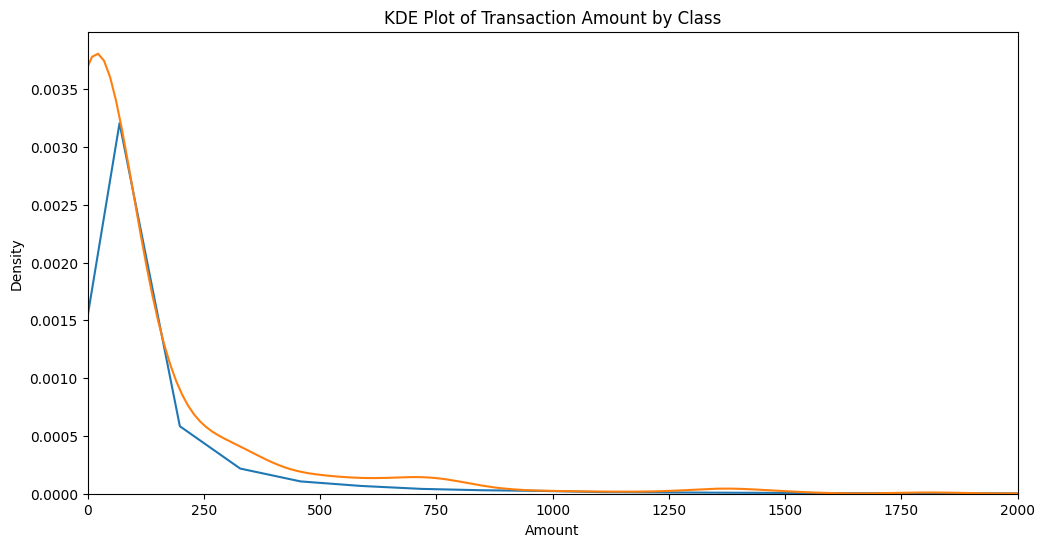

In [61]:
# KDE Plot of Transaction Amount for each class
plt.figure(figsize=(12, 6))
sns.kdeplot(df[df['Class'] == 0]['Amount'], label='Class 0')
sns.kdeplot(df[df['Class'] == 1]['Amount'], label='Class 1')
plt.title('KDE Plot of Transaction Amount by Class')
plt.xlim(0, 2000)  # Limiting x-axis for better readability
plt.show()

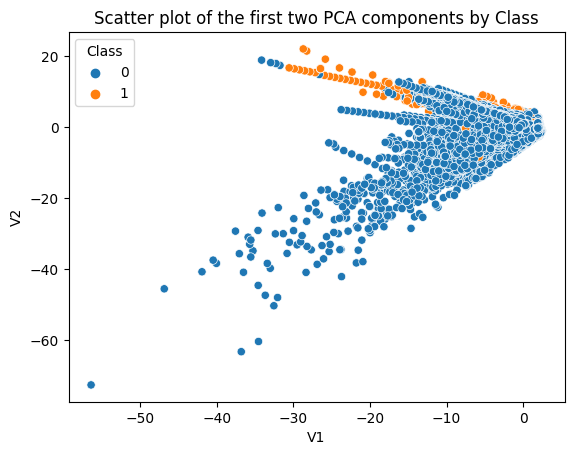

In [62]:
sns.scatterplot(x="V1", y="V2", hue="Class", data=df)
plt.title("Scatter plot of the first two PCA components by Class")
plt.show()

Modelling

MLP

In [63]:
#prepare
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv(file_path)

In [64]:
from sklearn.preprocessing import StandardScaler
# Standardization of the 'Amount' variable
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time', 'Amount'], axis=1)

In [65]:
# Resampling using undersampling method

# Count the number of fraud instances in the dataset and get the indices
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)
normal_indices = np.array(data[data.Class == 0].index)

# Randomly select non-fraud indices equal to the number of fraud instances
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)

# Combine fraud indices with randomly selected non-fraud indices
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# Extract data corresponding to the under-sampled indices
under_sample_data = data.iloc[under_sample_indices, :]


# The reason for undersampling is to address class imbalance in the dataset.
# By randomly selecting non-fraud instances equal to the number of fraud instances,
# we create a balanced dataset that helps prevent the model from being biased towards the majority class.
# This can improve the performance of the model in detecting the minority class (fraud).

In [66]:
# Define variables X and y
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [67]:
# Split into X and y for undersampling
X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

In [68]:
class CreditFraudDataset(Dataset):
    def __init__(self, split = "Train"):
        super(CreditFraudDataset, self).__init__()
        df = pd.read_csv(file_path).dropna().sample(frac = 1)
        self.df_x = df[["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28"]]
        self.df_y = df[["Class"]]
        #self.df_x[["Amount"]] /= 1000

        if split == "Train":
            self.x = torch.from_numpy(self.df_x.iloc[:227846].to_numpy()).type(torch.FloatTensor)
            self.y = torch.from_numpy(self.df_y.iloc[:227846].to_numpy()).type(torch.LongTensor).squeeze(1)
            self.len = self.x.shape[0]
        elif split == "Valid":
            self.x = torch.from_numpy(self.df_x.iloc[227846:280000].to_numpy()).type(torch.FloatTensor)
            self.y = torch.from_numpy(self.df_y.iloc[227846:280000].to_numpy()).type(torch.LongTensor).squeeze(1)
            self.len = self.x.shape[0]
        elif split == "Test":
            self.x = torch.from_numpy(self.df_x.iloc[280000:].to_numpy()).type(torch.FloatTensor)
            self.y = torch.from_numpy(self.df_y.iloc[280000:].to_numpy()).type(torch.LongTensor).squeeze(1)
            self.len = self.x.shape[0]
        else:
            print("Unknown Split")

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [69]:
# Create instances of the CreditFraudDataset for training, validation, and testing
train_data = CreditFraudDataset(split="Train")
valid_data = CreditFraudDataset(split="Valid")
test_data = CreditFraudDataset(split="Test")

# Create DataLoader instances for batching and shuffling the data during training
train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

# Create a DataLoader instance for testing with a batch size of 1 (each sample treated as a separate batch)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [70]:
# Define a custom neural network model for fraud detection
class FraudNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(FraudNet, self).__init__()

        # Define dropout layer with a dropout rate of 0.1
        self.dropout = nn.Dropout(p=0.1)

        # Define input layer with ReLU activation
        self.input_layer = nn.Sequential(nn.Linear(input_size, 64), nn.ReLU())

        self.h1 = nn.Sequential(nn.Linear(64, 128), nn.ReLU())
        self.h2 = nn.Sequential(nn.Linear(128, 256), nn.ReLU())
        self.h3 = nn.Sequential(nn.Linear(256, 512), nn.ReLU(), nn.BatchNorm1d(512))
        self.h4 = nn.Sequential(nn.Linear(512, 1024), nn.ReLU(), nn.BatchNorm1d(1024))
        self.h5 = nn.Sequential(nn.Linear(1024, 1024), nn.ReLU(), nn.Linear(1024, 1024), nn.ReLU(), nn.Linear(1024, 1024), nn.ReLU())
        self.h6 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(), nn.BatchNorm1d(512))
        self.h7 = nn.Sequential(nn.Linear(512, 128), nn.ReLU())
        self.h8 = nn.Sequential(nn.Linear(128, 32), nn.ReLU())

        # Define output layer
        self.output_layer = nn.Sequential(nn.Linear(32, output_size))

    def forward(self, x):
        # Apply dropout to the input layer
        x = self.dropout(self.input_layer(x))

        # Apply dropout to each hidden layer
        x = self.dropout(self.h1(x))
        x = self.dropout(self.h2(x))
        x = self.dropout(self.h3(x))
        x = self.dropout(self.h4(x))
        x = self.dropout(self.h5(x))
        x = self.dropout(self.h6(x))
        x = self.dropout(self.h7(x))
        x = self.dropout(self.h8(x))

        # Output layer without dropout for prediction
        x = self.output_layer(x)

        return x


In [71]:
# Create an instance of the FraudNet model with input size 28 and output size 2 (binary classification)
model = FraudNet(28, 2)

# Set hyperparameters for training
learning_rate = 0.001
epochs = 20

# Define the loss function (CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer with a learning rate and weight decay)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

# Set an initial minimum loss value to positive infinity for tracking the best model
min_loss = np.inf

# Move the model to the specified device (e.g., GPU if available)
model.to(device)

# Initialize lists to store training losses, validation losses, and accuracies during training
training_losses, valid_losses, accs = [], [], []


In [72]:
def train(min_loss):
    # Iterate over epochs
    for epoch in range(epochs):
        training_loss = 0
        model.train()

        # Iterate over training data batches
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)

            # Forward pass
            yhat = model(x)

            # Compute the loss
            loss = criterion(yhat, y)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            training_loss += loss.item()

        # Store the training loss for this epoch
        training_losses.append(training_loss)

        # Switch to evaluation mode for validation
        model.eval()
        valid_loss, acc = 0, 0

        # Disable gradient computation during validation
        with torch.no_grad():
            # Iterate over validation data batches
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)

                # Forward pass for validation
                yhat = model(x)

                # Compute the validation loss
                loss = criterion(yhat, y)

                # Accumulate validation loss
                valid_loss += loss.item()

                # Calculate accuracy
                _, top_class = yhat.topk(1, dim=1)
                eq = top_class == y.view(-1, 1)
                acc += eq.sum().item()

            # Store the validation loss for this epoch
            valid_losses.append(valid_loss)

            # Calculate accuracy percentage
            acc = (acc / len(valid_data)) * 100
            accs.append(acc)

        # Print training progress for the epoch
        print("EPOCH: {}.. \tTRAINING LOSS: {:.6f}.. \tVALIDATION LOSS: {:.6f}.. \tACCURACY: {:.2f}%..".format(epoch + 1, training_loss, valid_loss, acc))

        # Check if the current validation loss is lower than the minimum observed loss
        if valid_loss <= min_loss:
            print("Saving Model {:.3f} ---> {:.3f}".format(min_loss, valid_loss))
            # Save the model state and the new minimum loss
            save_obj = OrderedDict([
                ("model", model.state_dict()),
                ("min_loss", valid_loss)
            ])
            torch.save(save_obj, "fraud.pt")
            min_loss = valid_loss


In [73]:
train(min_loss)

EPOCH: 1.. 	TRAINING LOSS: 7.595937.. 	VALIDATION LOSS: 3.537628.. 	ACCURACY: 99.93%..
Saving Model inf ---> 3.538
EPOCH: 2.. 	TRAINING LOSS: 2.352122.. 	VALIDATION LOSS: 3.733965.. 	ACCURACY: 99.93%..
EPOCH: 3.. 	TRAINING LOSS: 2.165377.. 	VALIDATION LOSS: 4.025918.. 	ACCURACY: 99.86%..
EPOCH: 4.. 	TRAINING LOSS: 2.840537.. 	VALIDATION LOSS: 3.933127.. 	ACCURACY: 99.86%..
EPOCH: 5.. 	TRAINING LOSS: 1.977284.. 	VALIDATION LOSS: 3.325940.. 	ACCURACY: 99.93%..
Saving Model 3.538 ---> 3.326
EPOCH: 6.. 	TRAINING LOSS: 1.913036.. 	VALIDATION LOSS: 3.200321.. 	ACCURACY: 99.93%..
Saving Model 3.326 ---> 3.200
EPOCH: 7.. 	TRAINING LOSS: 1.895592.. 	VALIDATION LOSS: 3.544188.. 	ACCURACY: 99.93%..
EPOCH: 8.. 	TRAINING LOSS: 1.989072.. 	VALIDATION LOSS: 2.883820.. 	ACCURACY: 99.93%..
Saving Model 3.200 ---> 2.884
EPOCH: 9.. 	TRAINING LOSS: 1.915787.. 	VALIDATION LOSS: 3.240084.. 	ACCURACY: 99.93%..
EPOCH: 10.. 	TRAINING LOSS: 1.800670.. 	VALIDATION LOSS: 2.916289.. 	ACCURACY: 99.93%..
EPOCH: 11..

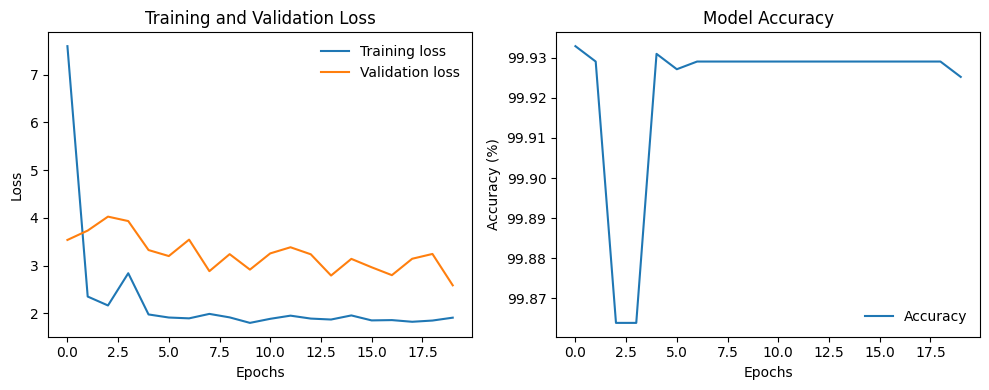

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(training_losses, label='Training loss')
ax1.plot(valid_losses, label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(frameon=False)

ax2.plot(accs, label='Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend(frameon=False)

plt.tight_layout() # Adjust layout to prevent overlap

In [103]:
total = 0
total_correct = 0
count = 0
confidence_scores = []

file = torch.load("fraud.pt")
model.load_state_dict(file['model'])

with torch.no_grad():
    model.eval()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        yhat = model(x)
        yhat = nn.Softmax(dim = 1)(yhat)
        top_p, top_class = yhat.topk(1, dim = 1)
        eq = top_class == y.view(-1, 1)
        total_correct += eq.sum().item()
        total += y.sum().item()

        confidence_scores.append(top_p.item() * 100)

        if count % 100 == 0:
            print("Predicted Value: {}.. \tConfidence: {:.2f}%.. \tGround Truth: {}".format(top_class.item(), top_p.item() * 100, y.item()))
        count += 1

print()
print()

accuracy_percentage = (total_correct / len(test_data)) * 100
print("Total Correct: {}/{} ({:.2f}%)".format(total_correct, len(test_data), accuracy_percentage))

Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.90%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.78%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%.. 	Ground Truth: 0
Predicted Value: 0.. 	Confidence: 99.96%

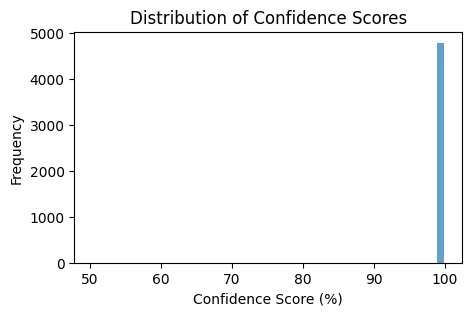

In [102]:
plt.figure(figsize=[5, 3])
plt.hist(confidence_scores, bins=50, alpha=0.7)
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score (%)')
plt.ylabel('Frequency')
plt.show()

Further explore: Autoencoder

In [82]:
#prepare
file_path = 'creditcard.csv'
cred_df = pd.read_csv(file_path)

In [83]:
#Trasnformation
# Change the time attribute in day
cred_df['Time'] = cred_df['Time'].apply(lambda t: (t/3600) % 24 )
# Sampling of data
normal_trans = cred_df[cred_df['Class'] == 0].sample(4000)
fraud_trans = cred_df[cred_df['Class'] == 1]
reduced_set = normal_trans.append(fraud_trans).reset_index(drop=True)
print(f"Cleansed dataset shape : {reduced_set.shape}")

Cleansed dataset shape : (4492, 31)


<ipython-input-83-63d2c7289dc8>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_set = normal_trans.append(fraud_trans).reset_index(drop=True)


In [84]:
# Splitting the dataset into X and y features
y = reduced_set['Class']
X = reduced_set.drop('Class', axis=1)

In [85]:
print(f"Shape of Features : {X.shape} and Target: {y.shape}")

Shape of Features : (4492, 30) and Target: (4492,)


In [86]:
scaler = RobustScaler().fit_transform(X)

# Scaled data
X_scaled_normal = scaler[y == 0]
X_scaled_fraud = scaler[y == 1]

In [87]:
print(f"Shape of the input data : {X.shape[1]}")

Shape of the input data : 30


In [88]:
#Building Autoencoder Mode
# Input layer with a shape of features/columns of the dataset
input_layer = Input(shape = (X.shape[1], ))

# Construct encoder network
encoded = Dense(100, activation= 'tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(25, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(12, activation = 'tanh', activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(6, activation='relu')(encoded)

# Decoder network
decoded = Dense(12, activation='tanh')(encoded)
decoded = Dense(25, activation='tanh')(decoded)
decoded = Dense(50, activation='tanh')(decoded)
decoded = Dense(100, activation='tanh')(decoded)

output_layer = Dense(X.shape[1], activation='relu')(decoded)

# Building a model
auto_encoder = Model(input_layer, output_layer)

In [89]:
# Compile the auto encoder model
auto_encoder.compile(optimizer='adadelta', loss='mse')

# Training the auto encoder model
train_encoder = auto_encoder.fit(X_scaled_normal, X_scaled_normal, batch_size=32, epochs=20, shuffle=True, validation_split=0.20)
train_encoder

Epoch 1/20
100/100 [==============================] - 3s 7ms/step - loss: 1.5187 - val_loss: 1.0420
Epoch 2/20
100/100 [==============================] - 0s 5ms/step - loss: 1.5183 - val_loss: 1.0416
Epoch 3/20
100/100 [==============================] - 1s 5ms/step - loss: 1.5179 - val_loss: 1.0412
Epoch 4/20
100/100 [==============================] - 1s 5ms/step - loss: 1.5176 - val_loss: 1.0408
Epoch 5/20
100/100 [==============================] - 1s 8ms/step - loss: 1.5172 - val_loss: 1.0405
Epoch 6/20
100/100 [==============================] - 1s 8ms/step - loss: 1.5168 - val_loss: 1.0401
Epoch 7/20
100/100 [==============================] - 1s 7ms/step - loss: 1.5165 - val_loss: 1.0397
Epoch 8/20
100/100 [==============================] - 1s 7ms/step - loss: 1.5161 - val_loss: 1.0393
Epoch 9/20
100/100 [==============================] - 1s 6ms/step - loss: 1.5158 - val_loss: 1.0390
Epoch 10/20
100/100 [==============================] - 0s 5ms/step - loss: 1.5154 - val_loss: 1.0386

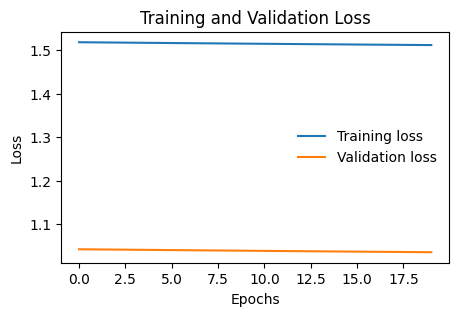

In [90]:
encoder_training_losses = train_encoder.history['loss']
encoder_valid_losses = train_encoder.history['val_loss']

plt.figure(figsize=[5,3])
plt.plot(encoder_training_losses, label='Training loss')
plt.plot(encoder_valid_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

In [91]:
#Using Autoencode to encode data
latent_model = Sequential()
latent_model.add(auto_encoder.layers[0])
latent_model.add(auto_encoder.layers[1])
latent_model.add(auto_encoder.layers[2])
latent_model.add(auto_encoder.layers[3])
latent_model.add(auto_encoder.layers[4])

In [92]:
# Predict latent space representations for normal & fruad transactions
normal_tran_points = latent_model.predict(X_scaled_normal)
fraud_tran_points = latent_model.predict(X_scaled_fraud)

# Combine latent space representations into a single collection
encoded_X = np.append(normal_tran_points, fraud_tran_points, axis=0)

# Create labels for normal transactions (0) and fraud transactions (1)
y_normal = np.zeros(normal_tran_points.shape[0])
y_fraud = np.ones(fraud_tran_points.shape[0])

encoded_y = np.append(y_normal, y_fraud, axis=0)

16/16 [==============================] - 0s 2ms/step


In [93]:
#Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_enc_train, X_enc_test, y_enc_train, y_enc_test = train_test_split(encoded_X, encoded_y, test_size=0.3)

In [94]:
print(f"Encoded train data X: {X_enc_train.shape}, Y: {y_enc_train.shape}, X_test :{X_enc_test.shape}, Y_test: {y_enc_test.shape}")
print(f"Actual train & test data X: {X_train.shape}, Y: {X_train.shape}, X_test :{X_test.shape}, Y_test: {y_test.shape}")

Encoded train data X: (3144, 12), Y: (3144,), X_test :(1348, 12), Y_test: (1348,)
Actual train & test data X: (3144, 30), Y: (3144, 30), X_test :(1348, 30), Y_test: (1348,)


In [95]:
#Non-linear Classifier
# Instance of SVM
svc_clf = SVC()

svc_clf.fit(X_train, y_train)

svc_predictions = svc_clf.predict(X_test)

In [96]:
print("Classification report \n {0}".format(classification_report(y_test, svc_predictions)))
print("Accuracy of SVC \n {:.2f}".format(accuracy_score(y_test, svc_predictions)))

Classification report 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1203
           1       1.00      0.50      0.67       145

    accuracy                           0.95      1348
   macro avg       0.97      0.75      0.82      1348
weighted avg       0.95      0.95      0.94      1348

Accuracy of SVC 
 0.95


In [97]:
#Linear Classifier
lr_clf = LogisticRegression()

lr_clf.fit(X_enc_train, y_enc_train)

# Predict the Test data
predictions = lr_clf.predict(X_enc_test)

In [98]:
print("Classification report \n {0}".format(classification_report(y_enc_test, predictions)))
print("Accuracy score is : {:.2f}".format(accuracy_score(y_enc_test, predictions)))

Classification report 
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1200
         1.0       0.94      0.74      0.83       148

    accuracy                           0.97      1348
   macro avg       0.95      0.87      0.90      1348
weighted avg       0.97      0.97      0.96      1348

Accuracy score is : 0.97


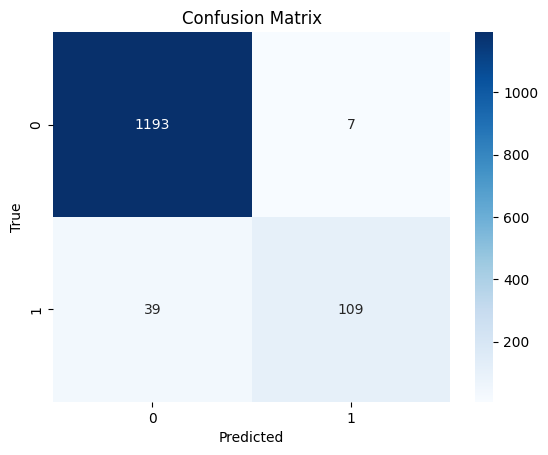

In [99]:
cm = confusion_matrix(y_enc_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()